In [32]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
ibm = pd.read_csv('../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [14]:
ibm.describe().T.shape

(26, 8)

In [12]:
ibm.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [13]:
type(ibm.loc[0, 'Department'])

str

In [15]:
numeric_cols = [col for col in ibm.columns if type(ibm.loc[0, col]) != str]
categoricals = [col for col in ibm.columns if col not in numeric_cols]

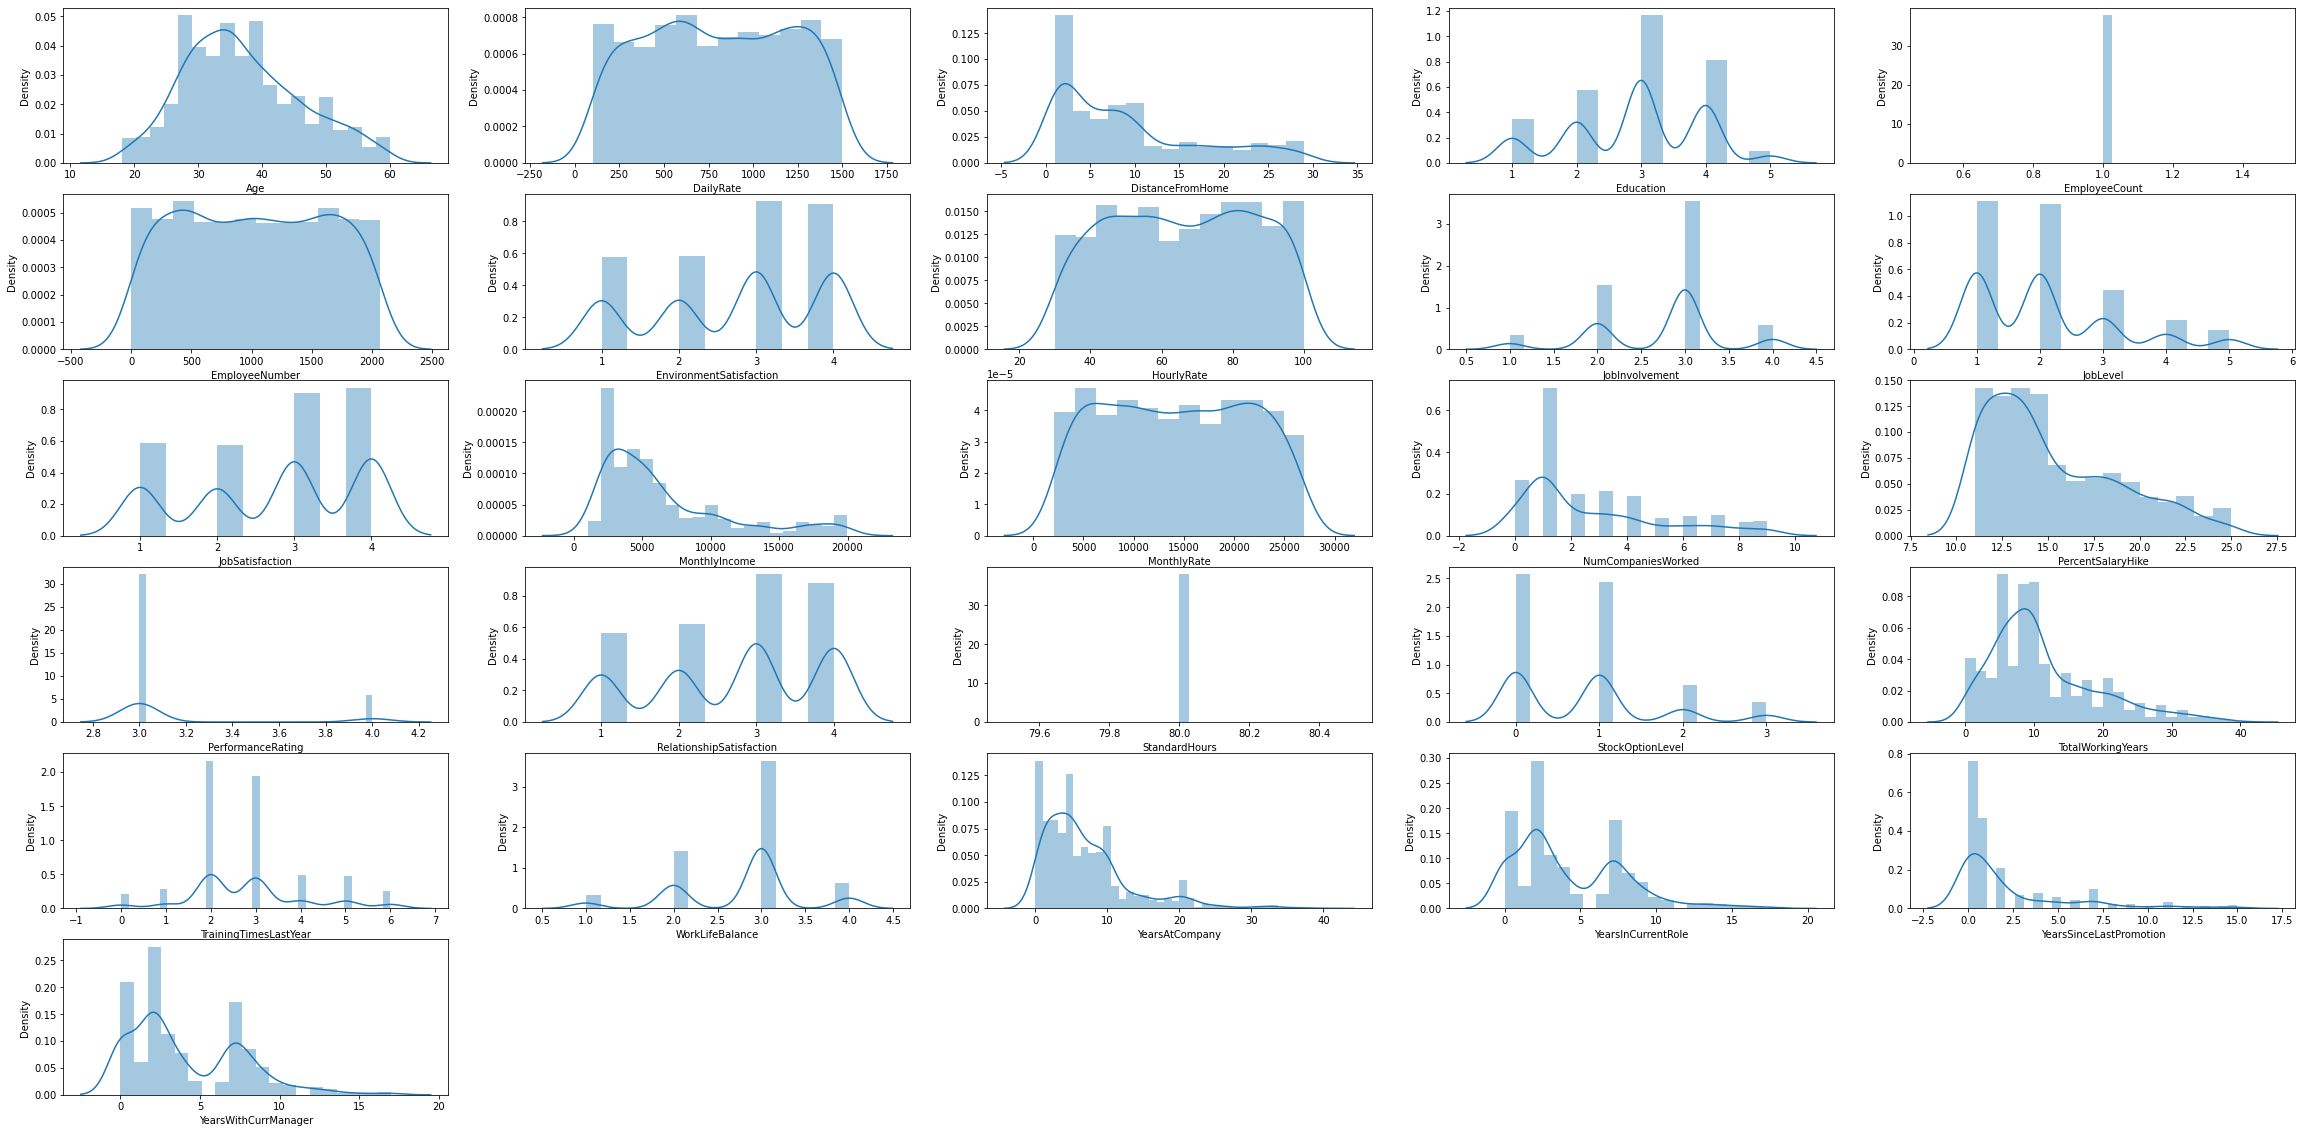

In [33]:
fig = plt.figure(1, figsize=(40, 20))
for i, col in enumerate(numeric_cols):
    fig.add_subplot(6, 5, i + 1)
    sns.distplot(ibm[col].dropna())
plt.show()
fig.savefig('../')